# Machine Learning - Prediction of Energy Consumption

## Simon Verheyen, 0094713, Physics
<b>The deadline for the assignment is 19/01/2020</b>.


## The dataset

The first step of any data processing project is to extract the data and prepare it for analysis. In the following section we will begin by loading the data and indexing it by the timestamp feature.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("data_electricity.csv")

## Index data by timestamp
datetime = pd.to_datetime(df.Date * (10 ** 9))
df['Datetime'] = datetime    # This timestamp should not be used during training
df.set_index('Datetime', inplace=True)

print("Dataset has", df.shape, "entries.")
print(f"\nData starts from: {df.index[0]}, until {df.index[-1]}")
print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
for col_name in df.columns:
    col = df[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")

Dataset has (419403, 10) entries.

Data starts from: 2010-01-03 03:01:00, until 2018-01-03 02:49:35

	Column               | Type     | Min          | Max         

	Date                 | int64    | 1262487660.0 | 1514947775.0
	Consumption_MW       | float64  |         44.0 |      26209.0
	Coal_MW              | float64  |       -485.0 |       5702.0
	Gas_MW               | float64  |       -414.0 |       2666.0
	Hidroelectric_MW     | float64  |          0.0 |       4728.0
	Nuclear_MW           | float64  |          0.0 |       1450.0
	Wind_MW              | float64  |       -521.0 |       7944.0
	Solar_MW             | float64  |         -6.0 |        859.0
	Biomass_MW           | float64  |          0.0 |        110.0
	Production_MW        | float64  |          0.0 |      11295.0


We can see that there are in total 419403 data points with 10 different features, listed above.

### Deleting Outliers

Since we will later be adding bool types to our dataset we will first take care of the outliers in the data. This is done with help of the scipy library with which we can calculate the z score for all the instances and discard the ones whose absolute value goes over 3. 

In [2]:
from scipy import stats

## remover outliers
new_df = df[(np.abs(stats.zscore(df))<3).all(axis=1)]

print("Dataset without outliers has", new_df.shape, "entries.")

Dataset without outliers has (395520, 10) entries.


Note that after the process of taking out the outliers we have 395 520 instances left. This means the process deemed around 23 883 to be outliers. Though this is a lot, since we have such a big dataset this is acceptable.

Now that the data is cleaned up and has all it needs we can split it into our training and test set. since we have data from a periode of over 8 years, we will use the final year as our test set.

This test set will only be used at the end to compare the accuracy of our final models. While the training data will later still be further split in a training and validation set.

In [3]:
## Split data into train / test 
from dateutil.relativedelta import relativedelta

eval_from = new_df.index.max() + relativedelta(months=-12)  # Here we set the 12 months threshold

train_old_df = df[df.index < eval_from]
test_old_df = df[df.index >= eval_from]

train_df = new_df[new_df.index < eval_from]
test_df = new_df[new_df.index >= eval_from]

print(f"Train data: {train_df.index.min()} -> {train_df.index.max()} | {len(train_df)} samples.")
print(f"Test data: {test_df.index.min()} -> {test_df.index.max()} | {len(test_df)} samples.")

Train data: 2010-01-03 03:01:00 -> 2017-01-03 02:40:14 | 350527 samples.
Test data: 2017-01-03 02:50:04 -> 2018-01-03 02:49:35 | 44993 samples.


### Data Visualization

The next block will be used to visualise data where needed to help us read it. We will project the data with and without outliers to verify the process succesfully took them out.

C:\Users\siver\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\siver\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\siver\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


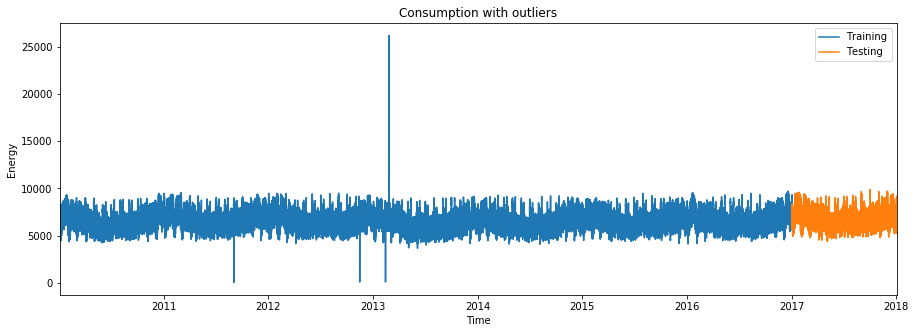

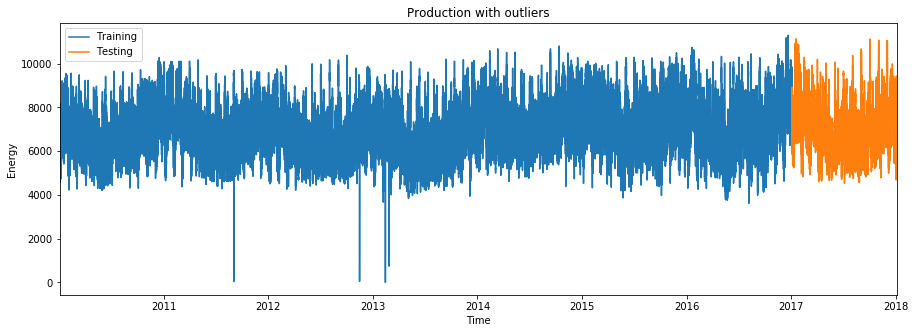

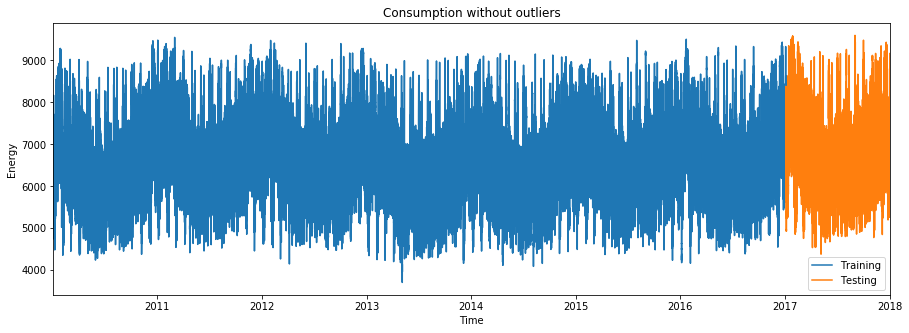

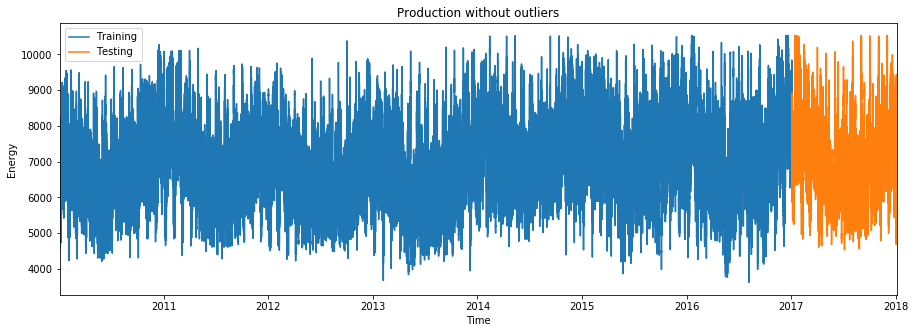

In [4]:
def plot_interval(base_data, test, date_from, date_to, column='Consumption_MW', title=None):
    plt.figure(figsize=(15,5))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.plot(base_data.index, getattr(base_data, column), label='Training')
    plt.plot(test.index, getattr(test, column), label='Testing')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)
    
plot_interval(train_old_df, test_old_df, train_old_df.index[0], test_old_df.index[-1], 'Consumption_MW', "Consumption with outliers")
plot_interval(train_old_df, test_old_df, train_old_df.index[0], test_old_df.index[-1], 'Production_MW', "Production with outliers")

plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Consumption_MW', "Consumption without outliers")
plot_interval(train_df, test_df, train_df.index[0], test_df.index[-1], 'Production_MW', "Production without outliers")

With this we can see that the outliers got succesfully taken out. 

### Expand time features

Before we begin with the actual models we will change the makup of our datasets by translating the 'Date' feature into few more features that the models can use, like month, week, day, ext.
After this we will also drop the 'Date' feature so we have a clean dataset. We will show the features that remain, with their type, min-, and max-value.

In [5]:
##add time info
def add_datetime_features(df):
    features = ["Year", "Week", "Day", "Dayofyear", "Month", "Dayofweek",
                "Is_year_end", "Is_year_start", "Is_month_end", "Is_month_start",
                "Hour", "Minute"]

    datetime = pd.to_datetime(df.Date * (10 ** 9))
    
    for feature in features:
        new_column = getattr(datetime.dt, feature.lower())
        df[feature] = new_column
    return df

train_data = add_datetime_features(train_df.copy())
test_data = add_datetime_features(test_df.copy())

to_drop = ['Date']

train_data.drop(columns=to_drop, inplace=True)
test_data.drop(columns=to_drop, inplace=True)

print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
for col_name in train_data.columns:
    col = train_data[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")


	Column               | Type     | Min          | Max         

	Consumption_MW       | float64  |       3709.0 |       9551.0
	Coal_MW              | float64  |        439.0 |       4090.0
	Gas_MW               | float64  |        116.0 |       2416.0
	Hidroelectric_MW     | float64  |          0.0 |       4102.0
	Nuclear_MW           | float64  |        651.0 |       1450.0
	Wind_MW              | float64  |        -26.0 |       2258.0
	Solar_MW             | float64  |         -6.0 |        554.0
	Biomass_MW           | float64  |          0.0 |        110.0
	Production_MW        | float64  |       3616.0 |      10536.0
	Year                 | int64    |       2010.0 |       2017.0
	Week                 | int64    |          1.0 |         53.0
	Day                  | int64    |          1.0 |         31.0
	Dayofyear            | int64    |          1.0 |        366.0
	Month                | int64    |          1.0 |         12.0
	Dayofweek            | int64    |          0.0 |    

### Selecting target

Next we will extract the target for our models from the training and test sets. In this case we're interested in predicting the energy consumption, which we can extract using pandas.

In [6]:
X_train = train_data.loc[:, train_data.columns != 'Consumption_MW']
X_test = test_data.loc[:, test_data.columns != 'Consumption_MW']

y_train = train_data.loc[:, train_data.columns == 'Consumption_MW'].values
y_test = test_data.loc[:, test_data.columns == 'Consumption_MW'].values

### Feature selection

Now that we have our targets we can perform the last step to get the data ready for the models to train on. Namely to select the interesting features. In this case we have a lot of features but no certainty that they will actually be usefull. Hence to save ourselfs some unneeded computations and don't make the models to complex we will use the feature_selection from sklearn to see and extract the interesting ones.

In [7]:
### Feature selection
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split

sel = SelectKBest(f_regression, k = 5)
sel.fit(X_train, y_train.flatten())

SelectKBest(k=5, score_func=<function f_regression at 0x0000023D9533D2F0>)

[2.21178983e+05 1.70921976e+05 7.34187048e+04 1.04507655e+04
 1.80091532e+03 3.63837718e+02 1.76254963e+02 1.68514158e+06
 2.37683334e+02 5.03050064e+00 1.19568841e+02 1.22495492e+01
 1.14514647e+01 9.09221322e+03 8.94213552e+01 2.10738206e+02
 3.48003272e+01 2.16190358e+03 1.00994077e+05 1.14867418e+01]


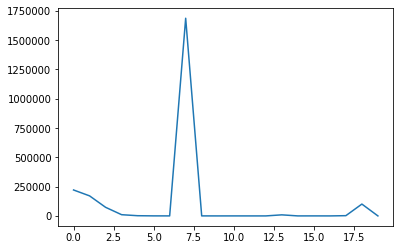

In [8]:
print(sel.scores_)
plt.plot(sel.scores_)
plt.show()

On the plot we can see, as we would expect that the Production_MW feature will be the most interesting.
Looking at the different values the feature_selection came up with, in this case we chose to keep 5 features. Since after the first 5, then next features have a sizable decrease in correlation.

Now that the feature_selection has selected the 5 best features, we will create the final train and test data sets by eliminating all other features and print what is left in the dataset.

In [9]:
# Extracting the index of important features
feature_idx = sel.get_support()

# Using the index to print the names of the important variables
sel_train_data = X_train.loc[:, X_train.columns[feature_idx]]
sel_test_data = X_test.loc[:, X_test.columns[feature_idx]]

print(f"\n\t{'Column':20s} | {'Type':8s} | {'Min':12s} | {'Max':12s}\n")
for col_name in sel_train_data.columns:
    col = sel_train_data[col_name]
    print(f"\t{col_name:20s} | {str(col.dtype):8s} | {col.min():12.1f} | {col.max():12.1f}")


	Column               | Type     | Min          | Max         

	Coal_MW              | float64  |        439.0 |       4090.0
	Gas_MW               | float64  |        116.0 |       2416.0
	Hidroelectric_MW     | float64  |          0.0 |       4102.0
	Production_MW        | float64  |       3616.0 |      10536.0
	Hour                 | int64    |          0.0 |         23.0


### Validation Set

Finally we will split the train set into a final training set and the validation set that we will use to optimize the model parameters. In this final step the data will also be randomized to have an extra level of control.

In [10]:
## Creation of validation set
Xtrain, Xval, ytrain, yval = train_test_split(sel_train_data.values, y_train.flatten(), test_size=0.2, random_state=42)

Xtest = sel_test_data.values
ytest = y_test.flatten()

Xtrain_all = sel_train_data.values
ytrain_all = y_train.flatten()

# The Models

For this case, since it is a regression problem, we will chose to train both a K-nearest neighbors and an Artificial Neural Network. Considering both of these have quite a different methodoligy, KNN being quite fast to train but taking longer on querry time, while ANN being the exact oposite of this.

Do note as well that for multi-dimentional data it is a bit better to use Raduis based Neighbors Regression, though in this case we will see how well the KNN actually does and compare it with a model that is very good in high dimentional data, namely ANN.

### K Nearest Neighbors

To start off with we will need to determine what will be the best parameter for the amount of neighbors the model looks at.
Firstly we will use our validation set to see which of the potential parameters will perform best by seeing where the model reaches the best accuracy on the validation set. After this point the model will overfit on the training data and perform worse on the validation set. 

For extra certainty on this question, we will also be using the cross-validation method at the same time. Which will perform the same test as we did, only by splitting the data into 10 sets and doing the validation test 10 times, where each of th 10 splits will be validated and scoring, we will look at the mean of these tests per model to test.

Note that since the cross validation will make it's own partions of the data set, we will feed it the entier data training data, instead of the what remained after we made a validation split ourselfs. Since this might put more bias in our results.

In [11]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor

#K values to try
Ks = np.arange(1,20)        

scores_knn1 = np.zeros(len(Ks))  
train_score_knn1 = np.zeros(len(Ks))
val_score_knn1 = np.zeros(len(Ks))
ind = 0

kf = 10 
num_folds=10
kf = KFold(n_splits = num_folds, shuffle = True)


for k in Ks:
    ##print("k-values ", k)
    knn = KNeighborsRegressor(n_neighbors=k)
    scores_knn1[ind] = np.mean(cross_val_score(knn, Xtrain_all, ytrain_all, cv=kf, scoring='r2'))
    
    knn.fit(Xtrain, ytrain)
    train_score_knn1[ind] = knn.score(Xtrain, ytrain)
    val_score_knn1[ind] = knn.score(Xval, yval)
    
    ind+=1

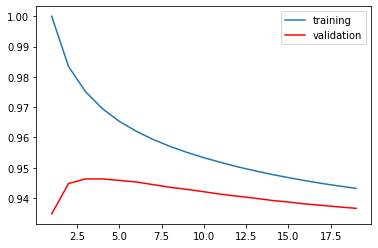

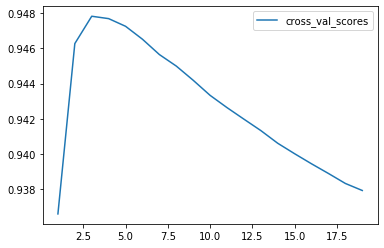

In [12]:
plt.figure()
plt.plot(Ks,train_score_knn1,label='training')
plt.plot(Ks,val_score_knn1,'r',label='validation')
plt.legend()
plt.show()

plt.figure()
plt.plot(Ks,scores_knn1,label='cross_val_scores')
plt.legend()
plt.show()

Here we're looking for the number of neighbors that will give the best score on the validation data without overfitting the on the training data. In this case we can see this will be 3 or 4 neighbors.
We will look at the exact values to get the best one.

In [13]:
print("Cross validated accuracy with 3 neighbors: ", (scores_knn1[2]))
print("Cross validated accuracy with 4 neighbors: ", (scores_knn1[3]))

Cross validated accuracy with 3 neighbors:  0.9478148163131668
Cross validated accuracy with 4 neighbors:  0.9476796832808958


Here we can see that the difference in performance isn't big, but still the model looking at 3 neighbors perfoms better so we will chose this as the parameter of our model.

As a last verification, we will iterate the training set over the model in steps of 1000 datapoints per step and see how well it does on our validation set. With this we can see the bias and variance of the model.

In [14]:
num_samples = np.arange(5,len(ytrain), 1000)

train_score_knn2 = np.zeros(len(num_samples))
val_score_knn2 = np.zeros(len(num_samples))

for ind, samples in enumerate(num_samples):
    ##print("samples ", samples)
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(Xtrain[0:samples,:], ytrain[0:samples])
    train_score_knn2[ind] = knn.score(Xtrain[0:samples,:], ytrain[0:samples])
    val_score_knn2[ind] = knn.score(Xval, yval)

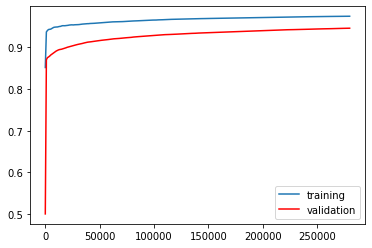

In [15]:
plt.figure()
plt.plot(num_samples,train_score_knn2,label='training')
plt.plot(num_samples,val_score_knn2,'r',label='validation')
plt.legend()
plt.show()

Here we can see that very quickly the model has a good prediction for the validation set and then over time slowelly converges to the predictions on the training data.

We can see that the bias is not to high and the outcome is functional. Though even with the large data set we have to work with, the variance on the model still remains larger then we would like.

With this we can finally create the model with the found optimal settings.

In [12]:
## final KNN model
knn_final = KNeighborsRegressor(n_neighbors=3).fit(Xtrain_all, ytrain_all)

### Artificial Neural Network

The next model to train is the ANN. This will be computationally a lot more intens, though it is better in handeling higher-dimentional data as well as large datasets.

Our first step here will be to scale the data using the StandardScaler in the preprocessing library of sklearn. This is done since training on the actual values will be to computationally heavy. Only the target data will be left untouched since we want to make predictions on these values.

In [11]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(Xtrain_all)
Xn_all = scaler.transform(Xtrain_all)
Xn = scaler.transform(Xtrain)
Xv = scaler.transform(Xval)
Xt = scaler.transform(Xtest)

Next we will have to follow the same steps as we did for the KNN model and find the best parameters for the model. Note that to save some time on the tests we will not iterate it to often on the data, though this will give us a worse estimate it will save time on the testing.
Later in the final model we will iterate more to have a better prediction.

We will be using the tanh activation function for good gradients and the lbfgs solver.

First we will have to optimize for the amount of hidden layers our network will use.

In [ ]:
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.model_selection import cross_val_score, KFold

#hidden units to try
num_hidden = np.arange(1,15)

scores_net1 = np.zeros(len(num_hidden))
train_score_net1 = np.zeros(len(num_hidden))
val_score_net1 = np.zeros(len(num_hidden))
ind = 0

num_folds=10
kf = KFold(n_splits = num_folds, shuffle = True)

for h in num_hidden:
    #print("Start ", h)
    net = mlp(hidden_layer_sizes = (h,), activation = 'tanh', solver = 'lbfgs', max_iter = 500)
    scores_net1[ind] = np.mean(cross_val_score(net, Xn, ytrain, cv=kf, scoring='neg_mean_squared_error'))
    
    net.fit(Xn, ytrain)
    train_score_net1[ind] = net.score(Xn, ytrain)
    val_score_net1[ind] = net.score(Xv, yval)
    
    ind += 1

In [ ]:
plt.figure()
plt.plot(num_hidden, scores_net1,label='cross_val_scores')
plt.legend()
plt.show()

As we can see when we look at the cross-validation. The model with 10 hidden layers has the best score and will be the one we continue with.

Following this we have a second parameter to optimize for, namely the decays, being a regulerization parameter, again we will use the cross validation technique to find the best one.

In [ ]:
#decays to try
decays=[0.00001,0.0001,0.001,0.01,0.1]

train_score_net2 = np.zeros(len(decays))
val_score_net2 = np.zeros(len(decays))

scores_net2 = np.zeros(len(decays))

num_folds=10
kf = KFold(n_splits = num_folds, shuffle = True)
ind = 0

for d in decays:
    #print("Start ", h)
    net = mlp(hidden_layer_sizes = (10,), alpha = d, activation = 'tanh', solver = 'lbfgs', max_iter = 500)
    scores_net2[ind] += np.mean(cross_val_score(net, Xn_all, ytrain_all, cv=kf, scoring='neg_mean_squared_error'))
    
    net.fit(Xn, ytrain)
    train_score_net2[ind] += net.score(Xn, ytrain)
    val_score_net2[ind] += net.score(Xv, yval)
    
    ind += 1

In [ ]:
plt.figure()
plt.plot(decays, scores_net2,label='cross_val_scores')
plt.xscale('log')
plt.legend()
plt.show()

In this case it is a lot more clear that the parameter with the best result will be a decay of 0.001.

With both parameters optimized we will again do the final verification for our ANN by training it in samples and seeing the evolution.

In [ ]:
num_samples = np.arange(4,len(ytrain), 10000)

#results on training/validation set
train_score_net3 = np.zeros(len(num_samples))
val_score_net3 = np.zeros(len(num_samples))

for idx, samples in enumerate(num_samples):
    ##print("samples ", samples)
    net = mlp(hidden_layer_sizes = (10,), alpha = 0.01, activation = 'tanh', solver = 'lbfgs', max_iter = 500)
    net.fit(Xn[0:samples,:], ytrain[0:samples])
    train_score_net3[idx] = net.score(Xn[0:samples,:], ytrain[0:samples])
    val_score_net3[idx] = net.score(Xv, yval)

In [ ]:
#plot learning curves
plt.figure()
plt.ylim((-0.1,1))
plt.plot(num_samples,train_score_net3,label='training')
plt.plot(num_samples,val_score_net3,'r',label='validation')
plt.legend()

Here I'm afraid something weird happens that I cannot truely account for. Namely the periodic dramatic dips in the performance. After an amount of different test, the same performance returns.

Going down the steps I think the data has been prepared properly, it seemed to work as intended on the KNN model and the scaling should be no problem either.
My assumption would be that I might have taken a incompatable type of machine learning algoritm but as I understood mlpregression would be ideal for this kind of multi-dimentional regression issue, assumably shown by the fact that when performing correctly, the accuracy is very good.

I would think the issue might lie in the fact that we do quite few iterations on the data, meaning that it can get stuck in local minima, or just not enough iterations to get to the optimal convergence for the weights.

Eitherway, we will continue with these parameters, though a lot more iterations for the final model, and look at the final score to compare it with the KNN model.

In [16]:
from sklearn.neural_network import MLPRegressor as mlp
net_final = mlp(hidden_layer_sizes = (10,), alpha = 0.01, activation = 'tanh', solver = 'lbfgs', max_iter = 5000)
net_final.fit(Xn_all, ytrain_all)

MLPRegressor(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=5000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

## Final testing

In [17]:
print("Final scoring: ")
print("K-nearest neighbors score:       ", knn_final.score(Xtest, ytest))
print("Artificial Neural Network score: ", net_final.score(Xt, ytest))

Final scoring: 
K-nearest neighbors score:        0.6234454924542298
Artificial Neural Network score:  0.7543606923112068


As we can see on the final accuracy scoring on the test data, the ANN model is indeed quite a bit more accurate then the KNN model.
Though even the ANN is less accurate then we would have hoped, so there is still some optimalization needed to make the model good enough for actal use.

For further development I would try and optimize a Raduis based Neighbors Regression, considering this will fair better then the KNN model. Or we could try to train the KNN very well on a single feature.

As for the ANN model, for further optimization we would have to look into more precise predictions, by doing more steps and iterating more on every step of the way to get a better indication of what the optimal parameters would be. We could also try an ANN with 2 or 3 hidden layers to see if this would perform better.

Though I'm afraid since I accidentally let the notebook run to often, which took a very long time for the ANN tests.